# 文本预处理 流程（原来的一样，不做变化）

1. 文本去噪
2. 中文分词
3. 过滤停用词
4. 词性标注 【没有特殊需求，咱们就不用做了
5. 文本去重 【考虑发表的用户，**官方号**
6. 文本标记【手动整理模型输入数据
7. 特征词选择

In [1]:
# 导入包
# 导入数据

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

import pkuseg
import jieba


In [2]:
data = pd.read_csv("../02Data/完整数据_暴雨_交通.csv")
df = data.sample(n=500, replace=False, random_state=1) # 指定随机种子，保证都是同一个数据组合
df.reset_index(drop=True, inplace=True)

tweets = df.loc[:99, ['微博正文']].astype("string") # 取100条数据就好了
tweets.head()

,微博正文
0,【面对暴雨，请收好这份#避险生存指南#】#蜀黍带你涨姿势#近日来，河南两小时暴雨记录又被刷新...
1,"#河南高速路况#截至2021年9月9日,19:00，目前省内高速通行情况：1、因收费站临时抢..."
2,郑州大暴雨灾害这波，今天回来又看到一交通事故，一个大叔满身血淋淋坐在车前，前几日杭州电瓶车骑...
3,【暖心！#交警暴雨中执勤频频被路人送伞#】6月10日17时许，浙江温州泰顺县一路口严重拥堵，...
4,【湖南多地迎暴雨！这些收费站仍在管制中】今日晚间，湖南部分地区突降暴雨，905中国交通广播派...


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   微博正文    100 non-null    string
dtypes: string(1)
memory usage: 928.0 bytes


## 1 文本去噪

微博中的特殊符号，对于算法的训练来说不太有利

[Python正则表达式清洗微博文本特殊符号(网址, @, 表情符等)](https://blog.csdn.net/blmoistawinde/article/details/103648044)

[附：表达式全集（正则表达式手册）](https://blog.csdn.net/qq_33472765/article/details/80785441)

In [4]:
def clear_noise(text):
    """
    text 待去噪的原始文本
    """
    text = text.replace(u'\xa0', u' ')      # 去除 \xa0     不间断空白符 
    text = text.replace(u'\u3000', u' ')    # 去除 \u3000   全角的空白符
    
    # 匹配这些中文标点符号 。 ？ ！ ， 、 ； ： “ ” ‘ ' （ ） 《 》 〈 〉 【 】 『 』 「 」 ﹃ ﹄ 〔 〕 … — ～ ﹏ ￥
    reg1 = r"@\S*?"
    reg2 = r'[\s|\u3002|\uff1f|\uff01|\uff0c|\u3001|\uff1b|\uff1a|\u201c|\u201d|\u2018|\u2019|\uff08|\uff09|\u300a|\u300b|\u3008|\u3009|\u3010|\u3011|\u300e|\u300f|\u300c|\u300d|\ufe43|\ufe44|\u3014|\u3015|\u2026|\u2014|\uff5e|\ufe4f|\uffe5]'
    text = re.sub(r"(回复)?(//)?\s*", "", text)  # 去除正文中的@和回复/转发中的用户名
    text = re.sub(reg1+reg2, "", text)
    text = re.sub(r"\[\S+\]", "", text)     # 去除表情符号
    # text = re.sub(r"#\S+\s*#", "", text)    # 去除话题内容 “#content#”
    # text = re.sub(r"【\S+\s*】", "", text)  # 分类标签“【content】”

    URL_REGEX = re.compile(
        r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))',
        re.IGNORECASE)
    text = re.sub(URL_REGEX, "", text)      # 去除网址
    
    EMAIL_REGEX = re.compile(r"[-a-z0-9_.]+@(?:[-a-z0-9]+\.)+[a-z]{2,6}", re.IGNORECASE)
    text = re.sub(EMAIL_REGEX, "", text)    # 去除邮件 
    
    text = text.replace("转发微博", "")      # 去除无意义的词语
    text = text.replace("网页链接", "")
    text = re.sub(r"\s+", " ", text)        # 合并正文中过多的空格

    text = re.sub(r"\d{2,4}年|\d{1,2}月|\d{1,2}日|\d{1,2}时|\d{1,2}分| \d{1,2}点", "", text) # 去除 日期 时间
    text = re.sub(r"\d", "", text)
    text = re.sub(r'[a-zA-Z]',"", text)
    
    return text.strip()

In [5]:
# # 之间的东西也会被删
text1 = "#河南高速路况#截至2021年9月9日,19:00，目前省内高速通行情况高速服务电话12328求助。#河南暴雨救援#"

text1, nu = re.subn(r"(#)?\S+\s*(#)?", "", text1)    # 去除话题内容 “#content#”
print("匹配次数：{}".format(nu))
text1

匹配次数：1


''

In [145]:
# 匹配这些中文标点符号 。 ？ ！ ， 、 ； ： “ ” ‘ ' （ ） 《 》 〈 〉 【 】 『 』 「 」 ﹃ ﹄ 〔 〕 … — ～ ﹏ ￥
reg1 = r"@\S*?"
reg2 = r'[\s|\u3002|\uff1f|\uff01|\uff0c|\u3001|\uff1b|\uff1a|\u201c|\u201d|\u2018|\u2019|\uff08|\uff09|\u300a|\u300b|\u3008|\u3009|\u3010|\u3011|\u300e|\u300f|\u300c|\u300d|\ufe43|\ufe44|\u3014|\u3015|\u2026|\u2014|\uff5e|\ufe4f|\uffe5]'
reg = r"(回复)?(//)?\s*"
text = "@复旦大学@上海交通大学@华东师范大学@同济大学 大家卷起来！！！看看这个台风看看这个暴雨！！你们哪个先停课就是最棒的！！！"
text = re.sub(reg1+reg2, "", text)
# text = re.sub(reg2,"", text)
text

'大家卷起来！！！看看这个台风看看这个暴雨！！你们哪个先停课就是最棒的！！！'

In [97]:
print(reg1 + reg2)

(回复)?(//)?\s*@\S*?\s*[\u3002|\uff1f|\uff01|\uff0c|\u3001|\uff1b|\uff1a|\u201c|\u201d|\u2018|\u2019|\uff08|\uff09|\u300a|\u300b]


In [6]:
tweets["去噪"] = tweets["微博正文"].apply(clear_noise).astype("string")
tweets.head()


,微博正文,去噪
0,【面对暴雨，请收好这份#避险生存指南#】#蜀黍带你涨姿势#近日来，河南两小时暴雨记录又被刷新...,【面对暴雨，请收好这份#避险生存指南#】#蜀黍带你涨姿势#近日来，河南两小时暴雨记录又被刷新...
1,"#河南高速路况#截至2021年9月9日,19:00，目前省内高速通行情况：1、因收费站临时抢...","#河南高速路况#截至,:，目前省内高速通行情况：、因收费站临时抢修施工，菏宝高速新乡东站（北..."
2,郑州大暴雨灾害这波，今天回来又看到一交通事故，一个大叔满身血淋淋坐在车前，前几日杭州电瓶车骑...,郑州大暴雨灾害这波，今天回来又看到一交通事故，一个大叔满身血淋淋坐在车前，前几日杭州电瓶车骑...
3,【暖心！#交警暴雨中执勤频频被路人送伞#】6月10日17时许，浙江温州泰顺县一路口严重拥堵，...,【暖心！#交警暴雨中执勤频频被路人送伞#】许，浙江温州泰顺县一路口严重拥堵，一名交警在疏导交...
4,【湖南多地迎暴雨！这些收费站仍在管制中】今日晚间，湖南部分地区突降暴雨，905中国交通广播派...,【湖南多地迎暴雨！这些收费站仍在管制中】今日晚间，湖南部分地区突降暴雨，中国交通广播派出四路...


In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   微博正文    100 non-null    string
 1   去噪      100 non-null    string
dtypes: string(2)
memory usage: 1.7 KB


## 2 中文分词

[pkuseg: 一个多领域中文分词工具包](https://github.com/lancopku/pkuseg-python)

[jieba: 结巴中文分词](https://github.com/fxsjy/jieba)

从github下载的用户则需要自己下载对应的预训练模型，并设置model_name字段为预训练模型路径。预训练模型可以在[release](https://github.com/lancopku/pkuseg-python/releases)部分下载。以下是对预训练模型的说明：

- **news**: 在MSRA（新闻语料）上训练的模型。【可以测试
- **web**: 在微博（网络文本语料）上训练的模型。【可以测试
- **medicine**: 在医药领域上训练的模型。
- **tourism**: 在旅游领域上训练的模型。
- **mixed**: 混合数据集训练的通用模型。随pip包附带的是此模型。【可以测试

我们还通过领域自适应的方法，利用维基百科的未标注数据实现了几个细领域预训练模型的自动构建以及通用模型的优化，这些模型目前仅可以在release中下载：

- **art**: 在艺术与文化领域上训练的模型。
- **entertainment**: 在娱乐与体育领域上训练的模型。
- **science**: 在科学领域上训练的模型。
- **default_v2**: 使用领域自适应方法得到的优化后的通用模型，相较于默认模型规模更大，但泛化性能更好。

In [8]:
# jieba分词

def jieba_segment(str, use_paddle=True):
    """
    jieba分词:
    str         : 待分词的文本
    use_paddle  : 是否使用paddle模型
    """
    word_list = jieba.cut(str, use_paddle=use_paddle)   # 分词后返回一个列表  jieba.cut(）   返回的是一个迭代器
    res = list(word_list)
   
    return res

#! 测试
jieba_segment('我爱北京天安门')


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\HONGTA~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.522 seconds.
Prefix dict has been built successfully.


['我', '爱', '北京', '天安门']

In [9]:
# pkuseg 分词 

def pkuseg_segment(str, m_name="web", u_dict="default"):
    """
    pkuseg分词:
    str     :待分词的文本
    m_name  : 选择使用的预训练模型
    u_dict  : 用户自定义的分词设置用户词典。
    """
    # m_name= "news"
    # m_name= "mixed"
    # p_tag= True # 是否包含词性
    seg = pkuseg.pkuseg(model_name=m_name, user_dict=u_dict)           # 以默认配置加载模型    
    res = seg.cut(str)  # 进行分词
   
    return res

#! 测试
pkuseg_segment('我爱北京天安门')

['我', '爱', '北京', '天安门']

In [10]:

tweets["jieba"] = tweets["去噪"].apply(jieba_segment)

In [11]:
#! 时间比较3min，轻易不尝试
tweets["pkuseg"] = tweets["去噪"].apply(pkuseg_segment)

In [12]:
tweets.to_excel("../02Data/jieba_pkuseg.xlsx")
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   微博正文    100 non-null    string
 1   去噪      100 non-null    string
 2   jieba   100 non-null    object
 3   pkuseg  100 non-null    object
dtypes: object(2), string(2)
memory usage: 3.2+ KB


## 3 过滤停用词

- 支持新增停用词库
- 考虑词性标准时的去停用词
- 支持删除指定词性的词

In [48]:
def clear_stopword(word_ls, stopword_file, postag=False, stop_postag=[], user_file="../05stopwords/user_stopwords.txt"):
    """
    word_ls         :待去停用词的词汇列表【word 或者是 tuple(word, postag) 组成的list
    stopword_file   :选择使用的停用词库
    user_file       :用户自定义的停用词库
    postag          :是否有词性标注
    stop_postag     :指定删除的词性
    """
    with open(stopword_file, 'r', encoding='utf-8') as f1, open(user_file, 'r' , encoding='utf-8') as f2:    # 
        
        stopword_ls = [word.strip('\n') for word in f1.readlines()] # 默认词库
        user_ls = [word.strip('\n') for word in f2.readlines()]     # 自定义词库

        stopword_ls.extend(user_ls)
        
        res = []
        if postag: # 有词性标注
            for word_tag in word_ls:
                w, t = word_tag
                if w not in stopword_ls and len(w) > 1 and t not in stop_postag: # 仅保留2个字符及以上的词
                    res.append((w, t))
        else:
            for w in word_ls:
                if w not in stopword_ls and len(w) > 1: # 仅保留2个字符及以上的词
                    res.append(w)
    
    return res


#! 测试
word_ls = tweets["jieba"][9]
stopword_file = "../05stopwords/hit_stopwords.txt"
postag = False
stop_postag = []
user_file = "../05stopwords/user_stopwords.txt"

res = clear_stopword(word_ls, stopword_file, postag, stop_postag, user_file)
print(res)

['辽宁', '天气', '我省', '大部分', '地区', '出现', '强对流', '天气', '注意', '防范', '雷雨大风', '短时', '强降水', '影响', '摘要', '预计', '我省', '大部分', '地区', '出现', '雷电', '大风', '短时', '强降水', '冰雹', '强对流', '天气', '西部', '北部', '地区', '最大', '瞬时', '风力', '局部', '可达级', '以上', '西部', '个别', '乡镇', '街道', '降雨量', '毫米', '最大', '小时', '降雨量', '毫米', '西部', '东南部', '地区', '强对流', '天气', '主要', '影响', '时段', '中午', '夜间', '北部', '地区', '夜间', '注意', '防范', '强对流', '天气', '带来', '不利', '影响', '气象条件', '分析', '蒙古', '中部', '高空槽', '东移', '过程', '加深', '高空', '冷涡', '低层', '偏南', '急流', '建立', '辽宁', '输送', '暖湿', '空气', '整层', '大气', '降水量', '水汽', '条件', '充足', '有利于', '出现', '短时', '强降水', '西部', '北部', '地区', '稳定', '能量', '充分', '积累', '对流', '有效', '逐渐', '增强', '配合', '垂直', '切变', '有利于', '对流', '系统', '发展', '出现', '大风', '冰雹', '强对流', '天气', '入海', '气旋', '影响', '白天', '夜间', '我省', '海区', '出现', '大风', '天气', '强对流', '天气预报', '我省', '大部分', '地区', '强对流', '天气', '预计', '锦州', '阜新', '铁岭', '朝阳', '盘锦', '葫芦岛', '地区', '康平', '法库', '新民', '台安', '雷电', '大风', '短时', '强降水', '冰雹', '强对流', '天气', '最大', '瞬时', '风力', '局部', '可达级', '以上', '最大', '小时', '降

In [50]:
stopword_file = "../05stopwords/hit_stopwords.txt"
postag = False
stop_postag = []
user_file = "../05stopwords/user_stopwords.txt"

tweets["jieba_stop"] = tweets["jieba"].apply(clear_stopword, args=[stopword_file, postag, stop_postag, user_file])
tweets["pkuseg_stop"] = tweets["pkuseg"].apply(clear_stopword, args=[stopword_file, postag, stop_postag, user_file])


In [15]:
tweets.to_excel("../02Data/jieba_pkuseg.xlsx")
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   微博正文         100 non-null    string
 1   去噪           100 non-null    string
 2   jieba        100 non-null    object
 3   pkuseg       100 non-null    object
 4   jieba_stop   100 non-null    object
 5   pkuseg_stop  100 non-null    object
dtypes: object(4), string(2)
memory usage: 4.8+ KB


In [16]:
# 测试特殊符号的长度

a = '⚠️'
b = '🌪️'
c = '🌬'
len(c)

1

## 4 分词+词性标注 


[pkuseg: 一个多领域中文分词工具包](https://github.com/lancopku/pkuseg-python)

[jieba: 结巴中文分词](https://github.com/fxsjy/jieba)



In [17]:
# jieba 词性标注（part-of-speech tagging）

def jieba_postag(str, use_paddle=True):
    """
    jieba分词:
    str         : 待分词的文本
    use_paddle  : 是否使用paddle模型
    """
    import jieba.posseg as pseg
    word_tag_ls = pseg.lcut(str, use_paddle=use_paddle)
    
    res = [] # 将词语与词性从pair对象转换为 元组，方便索引
    for w_t in word_tag_ls:
        w, t = w_t
        res.append((w, t))
    return res


#! 测试
res = jieba_postag('我爱北京天安门')
res

[('我', 'r'), ('爱', 'v'), ('北京', 'ns'), ('天安门', 'ns')]

In [18]:
# pkuseg 词性标注（part-of-speech tagging）
# pkuseg 分词 

def pkuseg_postag(str, m_name="web", u_dict="default", postag=True):
    """
    pkuseg分词:
    str     :待分词的文本
    m_name  : 选择使用的预训练模型
    u_dict  : 用户自定义的分词设置用户词典。
    postag   : 是否进行词性标准（是的话，需要在自定义的词典中，也要添加相应的词性 tab键隔开在一行
    """
    # m_name= "news"
    # m_name= "mixed"
    # postag= True # 是否包含词性
    seg = pkuseg.pkuseg(model_name=m_name, user_dict=u_dict, postag=postag)           # 以默认配置加载模型    
    res = seg.cut(str)  # 进行分词
   
    return seg.cut(str)  # 进行分词

#! 测试
res = pkuseg_postag('我爱北京天安门')
res

[('我', 'r'), ('爱', 'v'), ('北京', 'ns'), ('天安门', 'ns')]

In [19]:
#! 测试
word_str = tweets["去噪"][0]
print(word_str)

print("jieba:")
res = jieba_postag(word_str)
print(res)

print("pkuseg:")
res = pkuseg_postag(word_str)
print(res)


【面对暴雨，请收好这份#避险生存指南#】#蜀黍带你涨姿势#近日来，河南两小时暴雨记录又被刷新！接连不断的罕见暴雨袭击多个城市，熟悉的交通工具都变得不再安全，该如何远离“看不见的危险”?面对暴雨该如何避险脱困?戳视频↓收下这份生存指南！小央视频的微博视频
jieba:
[('【', 'x'), ('面对', 'v'), ('暴雨', 'n'), ('，', 'x'), ('请', 'v'), ('收好', 'v'), ('这份', 'mq'), ('#', 'x'), ('避险', 'v'), ('生存', 'v'), ('指南', 'n'), ('#', 'x'), ('】', 'x'), ('#', 'x'), ('蜀黍', 'n'), ('带', 'v'), ('你', 'r'), ('涨', 'v'), ('姿势', 'n'), ('#', 'x'), ('近日来', 'l'), ('，', 'x'), ('河南', 'ns'), ('两', 'm'), ('小时', 'n'), ('暴雨', 'n'), ('记录', 'n'), ('又', 'd'), ('被', 'p'), ('刷新', 'v'), ('！', 'x'), ('接连不断', 'l'), ('的', 'uj'), ('罕见', 'a'), ('暴雨', 'n'), ('袭击', 'v'), ('多个', 'm'), ('城市', 'ns'), ('，', 'x'), ('熟悉', 'v'), ('的', 'uj'), ('交通工具', 'l'), ('都', 'd'), ('变得', 'v'), ('不再', 'd'), ('安全', 'an'), ('，', 'x'), ('该', 'r'), ('如何', 'r'), ('远离', 'v'), ('“', 'x'), ('看不见', 'v'), ('的', 'uj'), ('危险', 'an'), ('”', 'x'), ('?', 'x'), ('面对', 'v'), ('暴雨', 'n'), ('该', 'r'), ('如何', 'r'), ('避险', 'v'), ('脱困', 'v'), ('?', 'x'), ('戳', 'v'), ('视频', 'n'), ('↓', 'x'), ('收下', 'v'), ('这份', 'mq

In [20]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   微博正文         100 non-null    string
 1   去噪           100 non-null    string
 2   jieba        100 non-null    object
 3   pkuseg       100 non-null    object
 4   jieba_stop   100 non-null    object
 5   pkuseg_stop  100 non-null    object
dtypes: object(4), string(2)
memory usage: 4.8+ KB


In [21]:
tweets["jieba_postag"] = tweets["去噪"].apply(jieba_postag)
tweets["pkuseg_postag"] = tweets["去噪"].apply(pkuseg_postag)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   微博正文           100 non-null    string
 1   去噪             100 non-null    string
 2   jieba          100 non-null    object
 3   pkuseg         100 non-null    object
 4   jieba_stop     100 non-null    object
 5   pkuseg_stop    100 non-null    object
 6   jieba_postag   100 non-null    object
 7   pkuseg_postag  100 non-null    object
dtypes: object(6), string(2)
memory usage: 6.4+ KB


In [22]:
#! 测试 带有词性标准的去停用词
word_ls = tweets["jieba_postag"][0]
stopword_file = "../05stopwords/hit_stopwords.txt"
postag = True
stop_postag = []
user_file = "../05stopwords/user_stopwords.txt"

res = clear_stopword(word_ls, stopword_file, postag, stop_postag, user_file) # 去噪
print(res)

[('面对', 'v'), ('暴雨', 'n'), ('收好', 'v'), ('这份', 'mq'), ('避险', 'v'), ('生存', 'v'), ('指南', 'n'), ('蜀黍', 'n'), ('姿势', 'n'), ('近日来', 'l'), ('小时', 'n'), ('暴雨', 'n'), ('记录', 'n'), ('刷新', 'v'), ('接连不断', 'l'), ('罕见', 'a'), ('暴雨', 'n'), ('袭击', 'v'), ('多个', 'm'), ('城市', 'ns'), ('熟悉', 'v'), ('交通工具', 'l'), ('变得', 'v'), ('不再', 'd'), ('安全', 'an'), ('远离', 'v'), ('看不见', 'v'), ('危险', 'an'), ('面对', 'v'), ('暴雨', 'n'), ('避险', 'v'), ('脱困', 'v'), ('视频', 'n'), ('收下', 'v'), ('这份', 'mq'), ('生存', 'v'), ('指南', 'n'), ('小央', 'n'), ('视频', 'n'), ('微博', 'a'), ('视频', 'n')]


In [53]:
stopword_file = "../05stopwords/hit_stopwords.txt"
postag = True
stop_postag = []
# stop_postag= ['c', 'd', 'df', 'f', 'm', 'mq', 'ns', 'nt', 'nz', 'o','p','q','r','s',',t','nrfg']

user_file = "../05stopwords/user_stopwords.txt"

tweets["jieba_postag_stop"] = tweets["jieba_postag"].apply(clear_stopword, args=[stopword_file, postag, stop_postag, user_file])
tweets["pkuseg_postag_stop"] = tweets["pkuseg_postag"].apply(clear_stopword, args=[stopword_file, postag, stop_postag, user_file])

In [24]:
tweets.to_excel("../02Data/jieba_pkuseg.xlsx")
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   微博正文                100 non-null    string
 1   去噪                  100 non-null    string
 2   jieba               100 non-null    object
 3   pkuseg              100 non-null    object
 4   jieba_stop          100 non-null    object
 5   pkuseg_stop         100 non-null    object
 6   jieba_postag        100 non-null    object
 7   pkuseg_postag       100 non-null    object
 8   jieba_postag_stop   100 non-null    object
 9   pkuseg_postag_stop  100 non-null    object
dtypes: object(8), string(2)
memory usage: 7.9+ KB


## 5 文本去重 【考虑发表的用户，**官方号**


## 6 文本标记

- 手动整理标记，模型输入数据

- 主题建模


In [146]:

a = [('面对', 'v')]
a = []
if a ==[]:
    a= [('','')]
np.array(a)[:, 0].tolist()

['']

In [147]:
a = pd.read_csv('../02Data/完整数据_暴雨_交通_pre_vec_TFIDF.csv')
a.head()

,同学,同心,同志,同意,同比,同舟,同行,同袍,同观路,同途,...,龙口市,龙吉,龙城,龙山,龙山镇,龙庭,龙桥,龙永段,龙背,龙舟
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 7 特征词选择

In [25]:
# 测试学习
import pandas as pd
import numpy as np
from  sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba

data=["移动共享，共享汽车，共享经济，共享单车",
     "财经栏目，财经政策，经济政策，共享经济"] 

# 需要提前分词

# 分词
cut_data=[]
for s in data:
    cut_s = jieba.cut(s)
    l_cut_s=' '.join(list(cut_s))    
    cut_data.append(l_cut_s)
    print(l_cut_s)
    
# 使用 CountVectorizer
print("+++++使用 CountVectorizer")
transfer = CountVectorizer(stop_words=["打算","就是"]) 
#实例化一个转换器类,
# # stop_words=["打算","就是"],去除不想要的词
data_new = transfer.fit_transform(cut_data)  #调用fit_transform()
print(data_new)
print(transfer.get_feature_names_out())
print(data_new.toarray()) 
#构建成一个二维表：
df=pd.DataFrame(data_new.toarray(),columns=transfer.get_feature_names_out())
print(df)   

# 使用 TfidfVectorizer
print("+++++使用 TfidfVectorizer")
transfer = TfidfVectorizer() #实例化一个转换器类
data_new = transfer.fit_transform(cut_data) #调用fit_transform()
print(data_new)
print(transfer.get_feature_names_out())
print(data_new.toarray()) 
#构建成一个二维表：
df=pd.DataFrame(data_new.toarray(),columns=transfer.get_feature_names_out())
print(df)

移动 共享 ， 共享 汽车 ， 共享 经济 ， 共享 单车
财经 栏目 ， 财经 政策 ， 经济 政策 ， 共享 经济
+++++使用 CountVectorizer
  (0, 5)	1
  (0, 0)	4
  (0, 4)	1
  (0, 6)	1
  (0, 1)	1
  (1, 0)	1
  (1, 6)	2
  (1, 7)	2
  (1, 3)	1
  (1, 2)	2
['共享' '单车' '政策' '栏目' '汽车' '移动' '经济' '财经']
[[4 1 0 0 1 1 1 0]
 [1 0 2 1 0 0 2 2]]
   共享  单车  政策  栏目  汽车  移动  经济  财经
0   4   1   0   0   1   1   1   0
1   1   0   2   1   0   0   2   2
+++++使用 TfidfVectorizer
  (0, 1)	0.2935323404273021
  (0, 6)	0.20885067778197156
  (0, 4)	0.2935323404273021
  (0, 0)	0.8354027111278862
  (0, 5)	0.2935323404273021
  (1, 2)	0.5889689090267317
  (1, 3)	0.29448445451336586
  (1, 7)	0.5889689090267317
  (1, 6)	0.41905622959186595
  (1, 0)	0.20952811479593297
['共享' '单车' '政策' '栏目' '汽车' '移动' '经济' '财经']
[[0.83540271 0.29353234 0.         0.         0.29353234 0.29353234
  0.20885068 0.        ]
 [0.20952811 0.         0.58896891 0.29448445 0.         0.
  0.41905623 0.58896891]]
         共享        单车        政策        栏目        汽车        移动        经济  \
0  0.835403  0.2935

In [26]:
# 使用封装
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def wordVectorizer(word_ls_column, v_type, postag=True):
    ls_str=[]
    if postag:
        for word_tag_ls in word_ls_column:
            if word_tag_ls == []: # 避免空的词
                word_tag_ls = [('','')]
            word_ls = np.array(word_tag_ls)[:, 0].tolist()
            tag_ls = np.array(word_tag_ls)[:, 1].tolist()
            
            strs = ' '.join(word_ls)
            ls_str.append(strs)
    else:
        for word_ls in word_ls_column:
            strs = ' '.join(word_ls) 
            ls_str.append(strs)
    
    if v_type.upper() == "TFIDF":
    # TF-IDF(term frequency—inverse document frequency)
        transfer = TfidfVectorizer() #实例化一个转换器类
    else:
        transfer = CountVectorizer()
    data_new = transfer.fit_transform(ls_str) #调用fit_transform()
    #构建成一个二维表：
    df=pd.DataFrame(data_new.toarray(), columns=transfer.get_feature_names_out())
    
    withWeight = transfer.vocabulary_
    return df, withWeight

In [27]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   微博正文                100 non-null    string
 1   去噪                  100 non-null    string
 2   jieba               100 non-null    object
 3   pkuseg              100 non-null    object
 4   jieba_stop          100 non-null    object
 5   pkuseg_stop         100 non-null    object
 6   jieba_postag        100 non-null    object
 7   pkuseg_postag       100 non-null    object
 8   jieba_postag_stop   100 non-null    object
 9   pkuseg_postag_stop  100 non-null    object
dtypes: object(8), string(2)
memory usage: 7.9+ KB


In [28]:
# 测试 获取 单词和词性
word_ls_column = tweets["jieba_postag_stop"] # 从excel再读取回来，就不是list 和（）数据了

word_tag_ls = word_ls_column[0]
word_ls = np.array(word_tag_ls)[:, 0].tolist()
tag_ls = np.array(word_tag_ls)[:, 1].tolist()
print(word_ls)
print(tag_ls)

['面对', '暴雨', '收好', '这份', '避险', '生存', '指南', '蜀黍', '姿势', '近日来', '小时', '暴雨', '记录', '刷新', '接连不断', '罕见', '暴雨', '袭击', '多个', '城市', '熟悉', '交通工具', '变得', '不再', '安全', '远离', '看不见', '危险', '面对', '暴雨', '避险', '脱困', '视频', '收下', '这份', '生存', '指南', '小央', '视频', '微博', '视频']
['v', 'n', 'v', 'mq', 'v', 'v', 'n', 'n', 'n', 'l', 'n', 'n', 'n', 'v', 'l', 'a', 'n', 'v', 'm', 'ns', 'v', 'l', 'v', 'd', 'an', 'v', 'v', 'an', 'v', 'n', 'v', 'v', 'n', 'v', 'mq', 'v', 'n', 'n', 'n', 'a', 'n']


In [62]:
# 测试
vec_type = "TFIDF"
word_ls_column = tweets["jieba_postag_stop"]
word_v, withWeight = wordVectorizer(word_ls_column, vec_type, postag=True)
# word_v.head()
# word_v.info()
# withWeight

{'面对': 2053,
 '暴雨': 1160,
 '收好': 1068,
 '这份': 1870,
 '避险': 1921,
 '生存': 1472,
 '指南': 1012,
 '蜀黍': 1699,
 '姿势': 691,
 '近日来': 1867,
 '小时': 773,
 '记录': 1762,
 '刷新': 379,
 '接连不断': 1039,
 '罕见': 1638,
 '袭击': 1717,
 '多个': 631,
 '城市': 605,
 '熟悉': 1428,
 '交通工具': 174,
 '变得': 485,
 '不再': 54,
 '安全': 705,
 '远离': 1877,
 '看不见': 1523,
 '危险': 450,
 '脱困': 1660,
 '视频': 1743,
 '收下': 1067,
 '小央': 770,
 '微博': 917,
 '高速': 2112,
 '路况': 1802,
 '截至': 966,
 '目前': 1511,
 '省内': 1521,
 '通行': 1905,
 '情况': 945,
 '收费站': 1071,
 '临时': 114,
 '抢修': 989,
 '施工': 1119,
 '新乡': 1101,
 '东站': 83,
 '北口': 410,
 '禁止': 1544,
 '路面': 1816,
 '条件': 1204,
 '受限': 484,
 '商登': 539,
 '安罗': 716,
 '互通': 155,
 '处以': 623,
 '东至': 84,
 '尉氏': 765,
 '北站': 411,
 '主线': 125,
 '以上': 207,
 '客车': 733,
 '货车': 1785,
 '地方': 581,
 '道路': 1913,
 '积水': 1557,
 '损毁': 1028,
 '焦桐': 1423,
 '仅限': 196,
 '小型': 768,
 '车辆': 1830,
 '地磅': 583,
 '故障': 1077,
 '超化': 1796,
 '寺站': 754,
 '提前': 1049,
 '绕行': 1629,
 '高速公路': 2113,
 '正常': 1245,
 '交警': 166,
 '提示': 1051,
 '遇到': 1911,
 '

## 测试

### 查看词性的词汇 及 数量对比

(6099, 2)
(6432, 2)
['n', 'v', 'ns', 'vn', 'a', 'b', 'd', 't', 'nr', 'f', 'ad', 's', 'j', 'an', 'i', 'm', 'r', 'nz', 'q', 'z', 'l', 'vd', 'u', 'p', 'nt', 'c']


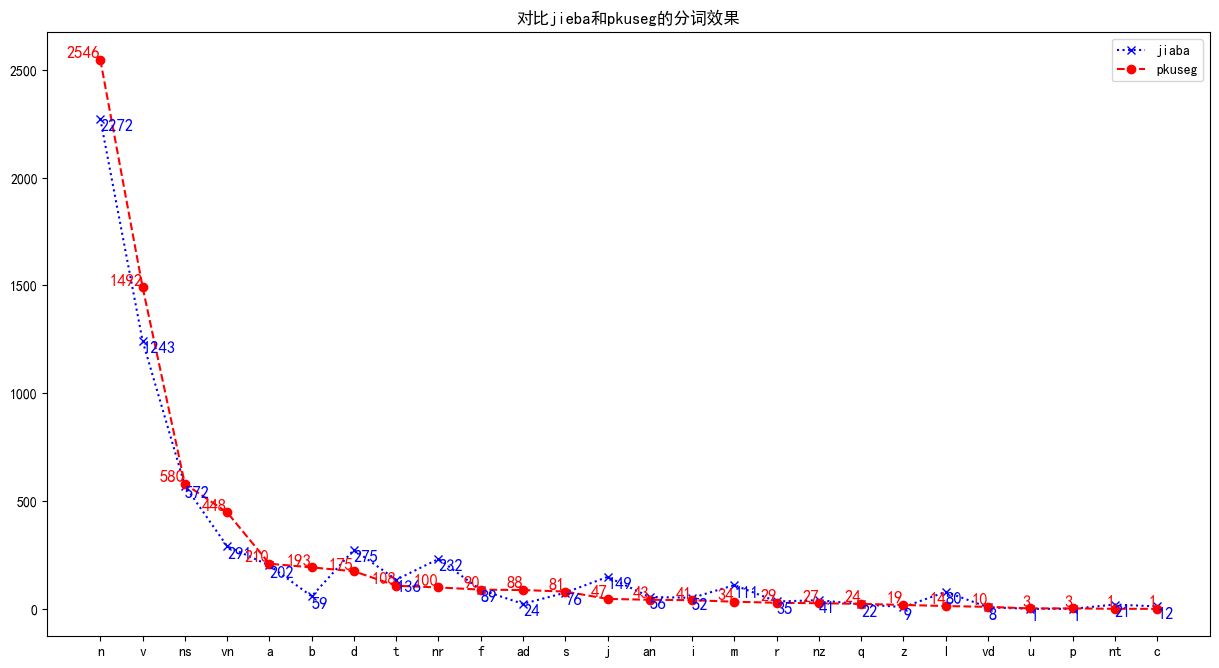

In [55]:
# jieba分词
word_ls_column = tweets["jieba_postag_stop"] # 从excel再读取回来，就不是[(),()] 和数据了
word  =[]
tag = []
for word_tag_ls in word_ls_column: # 遍历一整列的每一行
    word_ls = np.array(word_tag_ls)[:, 0].tolist()
    tag_ls = np.array(word_tag_ls)[:, 1].tolist()
    word.extend(word_ls)
    tag.extend(tag_ls)
df_jieba = pd.DataFrame({'word': word,
                   'tag' : tag})        
print(df_jieba.shape)


# pkuseg分词
word_ls_column = tweets["pkuseg_postag_stop"] # 从excel再读取回来，就不是[(),()] 和数据了
word  =[]
tag = []
for word_tag_ls in word_ls_column: # 遍历一整列的每一行
    word_ls = np.array(word_tag_ls)[:, 0].tolist()
    tag_ls = np.array(word_tag_ls)[:, 1].tolist()
    word.extend(word_ls)
    tag.extend(tag_ls)
df_pkuseg = pd.DataFrame({'word': word,
                   'tag' : tag})        
print(df_pkuseg.shape)



val_count_jieba = df_jieba['tag'].value_counts()
val_count_pkuseg = df_pkuseg['tag'].value_counts()


# 找出共同的 词性tag
x_tag = []
for t in val_count_pkuseg.index:
    if t in val_count_jieba.index:
        x_tag.append(t)
print(x_tag)

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(x_tag, val_count_jieba.loc[x_tag], marker="x", c='b',ls=":", label="jiaba")
for a, b in zip(x_tag, val_count_jieba.loc[x_tag]):
    plt.text(a, b, "{}".format(b), ha='left', va='top', fontsize=12, c='b')

plt.plot(x_tag, val_count_pkuseg.loc[x_tag], marker="o", c='r', ls="--", label="pkuseg")
for a, b in zip(x_tag, val_count_pkuseg.loc[x_tag]):
    plt.text(a, b, "{}".format(b), ha='right', va='bottom', fontsize=12, c='r')
plt.title("对比jieba和pkuseg的分词效果")
plt.legend()

plt.savefig("./figure/jieba-pkuseg词性分配数量对比.png")

In [ ]:
help(plt.text)

In [56]:
# 使用jieba分词的结果 输出打印
grouped_single =  df_jieba.groupby(by='tag') # jieba为例
# grouped_single =  df_pkuseg.groupby(by='tag') # pkuseg为例
print(f"组数：{grouped_single.ngroups}")

import os
filename = "../02Data/各词性下的具体词汇信息.txt"
if os.path.exists(filename):
    os.remove(filename)

with open(filename, 'a') as f:
    for name, group in grouped_single:
        
        f.write(f"词性: {name}\n")
        row_len = 20 # 每行打印多少词汇
        l = group['word'].shape[0] // row_len
        for i in range(l):
            f.write(' '.join(group['word'][i* row_len: (i+1)*row_len]))
            f.write("\n")
        f.write(' '.join(group['word'][l*row_len:]))
        f.write("\n")
        f.write("\n\n")

        # print(name)
        # display(group['word'].head())

组数：31


In [300]:
list(range(6))

[0, 1, 2, 3, 4, 5]